# Assignment 3
### Due 9/23. Do four of five.

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

1. 
- Open the NHANES (or Ames prices or college completion datasets, if you prefer)
- Find two categorical variables of interest (there are 198, and short descriptions are given in the `nhanes_meta_17_18.csv` file). Investigate their missing values (you don't have to focus on missing values for this analysis like we did with police use of force, but always be aware of how dirty the data are)
- Compute a contingency table for your categorical $X$ and $Y$
- Discuss any interesting patterns (or lack of one) that you observe

In [106]:
nhanes_meta = pd.read_csv("data/nhanes_meta_17_18.csv")
nhanes_data = pd.read_csv("data/nhanes_data_17_18.csv")

var_x = "GeneralHealthCondition"        # Self-reported health status
var_y = "TriedToLoseWeightInPastYear"   # Tried to lose weight in past year (0/1)

subset = nhanes_data[[var_x, var_y]]

missing_data = subset.isna().sum()
missing_percent = missing_data / len(subset)

print("Percent of Missing Values:\n", missing_percent*100, "\n")

Percent of Missing Values:
 GeneralHealthCondition         28.711451
TriedToLoseWeightInPastYear    39.194358
dtype: float64 



C:\Users\linod\AppData\Local\Temp\ipykernel_14796\4220381036.py:2: DtypeWarning: Columns (142) have mixed types. Specify dtype option on import or set low_memory=False.
  nhanes_data = pd.read_csv("data/nhanes_data_17_18.csv")


28.7% of general health condition data and 39.2% of tried to lose weight in past year data is missing in this data set.

In [107]:
contingency = pd.crosstab(subset[var_x], subset[var_y], margins=True)
print("Contingency table:\n", contingency, "\n")

Contingency table:
 TriedToLoseWeightInPastYear   0.0   1.0   All
GeneralHealthCondition                       
Excellent                     307   144   451
Fair or                       548   423   971
Good                         1139   827  1966
Poor?                          91    59   150
Very good                     729   450  1179
All                          2814  1903  4717 



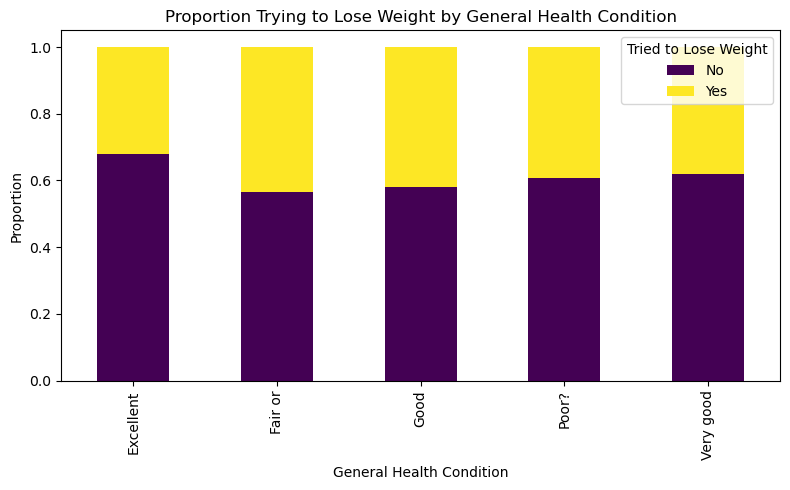

In [108]:
prop_table = pd.crosstab(subset[var_x], subset[var_y], normalize="index")
prop_table.plot(
    kind="bar",
    stacked=True,
    figsize=(8, 5),
    colormap="viridis"
)

plt.title("Proportion Trying to Lose Weight by General Health Condition")
plt.xlabel("General Health Condition")
plt.ylabel("Proportion")
plt.legend(title="Tried to Lose Weight", labels=["No", "Yes"])
plt.tight_layout()
plt.show()

It is interesting that the lowest proportion of people who tried to lost weight in the last year consider themselves to be in "excellent" condition. There is little variation between people in other health categories, but the highest proportion of people who tried to lose weight in the last year describe themselves to be in "fair" condition.

2. 
- Open the NHANES dataset
- Find a categorical and numeric variable of interest (there are 198, and short descriptions are given in the `nhanes_meta_17_18.csv` file). Investigate their missing values (you don't have to focus on missing values for this analysis, but always be aware of them)
- Make descriptive tables and grouped kernel density plots to represent the variation in your numeric $Y$ conditional on your categorical $X$
- Discuss any interesting patterns (or lack of one) that you observe

In [109]:
var_x = "EverBreastfedOrFedBreastmilk"
var_y = "WeightKg"

subset = nhanes_data[[var_x, var_y]]

missing_data = subset.isna().sum()
missing_percent = missing_data / len(subset)

print("Percent of Missing Values:\n", missing_percent*100, "\n")

Percent of Missing Values:
 EverBreastfedOrFedBreastmilk    87.222089
WeightKg                         1.482190
dtype: float64 



In [110]:
subset = nhanes_data[[var_x, var_y]].dropna()

In [111]:
desc_table = subset.groupby(var_x)[var_y].describe()
print(desc_table)

                              count       mean       std  min    25%   50%  \
EverBreastfedOrFedBreastmilk                                                 
0.0                           203.0  17.995074  5.835906  8.7  13.45  17.2   
1.0                           846.0  16.804255  5.381934  8.3  12.80  15.8   

                               75%   max  
EverBreastfedOrFedBreastmilk              
0.0                           21.3  38.7  
1.0                           19.5  45.2  


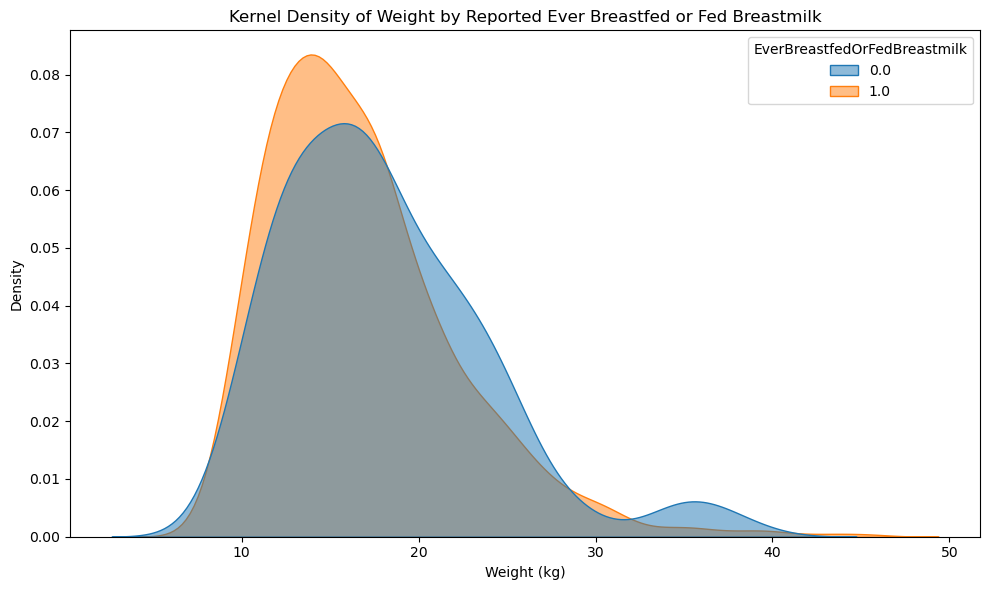

In [112]:
plt.figure(figsize=(10,6))
sns.kdeplot(
    data=subset, 
    x=var_y, 
    hue=var_x, 
    common_norm=False, 
    fill=True, 
    alpha=0.5
)

plt.title("Kernel Density of Weight by Reported Ever Breastfed or Fed Breastmilk")
plt.xlabel("Weight (kg)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

The analysis indicates that individuals who were breastfed or fed breastmilk weigh, on average, slightly more than those who were not. While the difference is relatively small, it is consistent across the data. This finding should be interpreted cautiously: the relationship is correlational and does not necessarily imply causation. Weight outcomes are influenced by a wide range of factors including genetics, socioeconomic conditions, diet quality, and lifestyle habits, any of which could confound the association between early feeding practices and later body weight. Moreover, substantial variation exists within both groups, underscoring that breastfeeding status alone is not a strong predictor of weight. Taken together, the results highlight a modest association that contributes to ongoing discussions about the long-term impacts of breastfeeding, while reinforcing the importance of considering broader contextual and environmental influences on health outcomes.

3. 
We showed that the mean and median could be discovered by minimizing various kinds of loss functions; this is what machine learning is. To make a prediction $\hat{y}(z)$ of $Y$ when $X=z$, minimize the mean squared error:
$$
MSE(\hat{y}(z)) = \dfrac{1}{N} \sum_{i=1}^N \left\lbrace y_i - \hat{y}(z) \right\rbrace^2 \frac{1}{h}k\left(\frac{z-x_i}{h}\right)
$$
Show that the solution to this problem is the LCLS/Naradaya-Watson estimator.

We want to find where $\hat{y}(z)$ minimizes the mean squared error. To do this, we must take the derivative of $MSE(\hat{y}(z))$ with respect to $\hat{y}$, set it equal to 0, and finally solve for $\hat{y}$.

These steps below show exactly how to do that.

1. Drop multiplication constants: $Q(\hat{y}) \;=\; \sum_{i=1}^N k\!\left(\frac{z-x_i}{h}\right)\,(y_i - \hat{y})^2$

2. Take the derivative w.r.t $\hat{y}$: $\frac{dQ}{d\hat{y}} \;=\; \sum_{i=1}^N 2\,k\!\left(\frac{z-x_i}{h}\right)\,(\hat{y} - y_i)$

3. Drop constants and set to 0: $\sum_{i=1}^N k\!\left(\frac{z-x_i}{h}\right)\,(\hat{y} - y_i) \;=\; 0$

4. Separate terms: $\hat{y}\,\sum_{i=1}^N k\!\left(\frac{z-x_i}{h}\right) \;=\; \sum_{i=1}^N k\!\left(\frac{z-x_i}{h}\right)\,y_i$

5. Solve for $\hat{y}$: $\hat{y}(z) \;=\; \frac{\sum_{i=1}^N k\!\left(\frac{z-x_i}{h}\right)\,y_i}{\sum_{i=1}^N k\!\left(\frac{z-x_i}{h}\right)}$ This is the LCLS/Naradaya-Watson estimator.



5. 
- In any of the available data sets, investigate the relationships between pairs of variables $(X,Y)$ with a scatterplot and CEF (for example, price on area)
- Is this relationship plausibly causal, or are there missing variables that might explain at least part of the relationship between your variables? These can be "conceptual" rather than "practical"; for example, 'talent' or 'grit' probably explain education outcomes, but are almost impossible to measure. We are asking whether there are hypothetical **threats to causal identification** of the effect of $X$ on $Y$.
- Explain how, regardless of the threat to causal identification, you can still use your model to predict $Y$ given $X$, as long as you don't intervene in the system to control the outcome

In [113]:
x_var = "BodyMassIndexKgm2"
y_var = "WaistCircumferenceCm"

subset = nhanes_data[[x_var, y_var]].dropna()

C:\Users\linod\AppData\Local\Temp\ipykernel_14796\2932363645.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


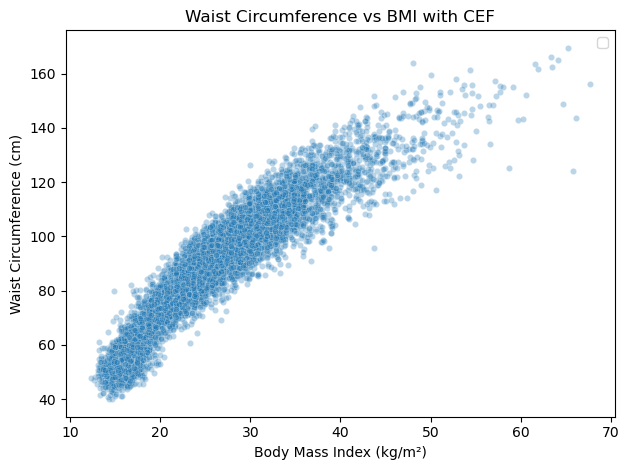

In [114]:
sns.scatterplot(data=subset, x=x_var, y=y_var, alpha=0.3, s=20)
plt.title("Waist Circumference vs BMI with CEF")
plt.xlabel("Body Mass Index (kg/m²)")
plt.ylabel("Waist Circumference (cm)")
plt.legend()
plt.tight_layout()
plt.show()


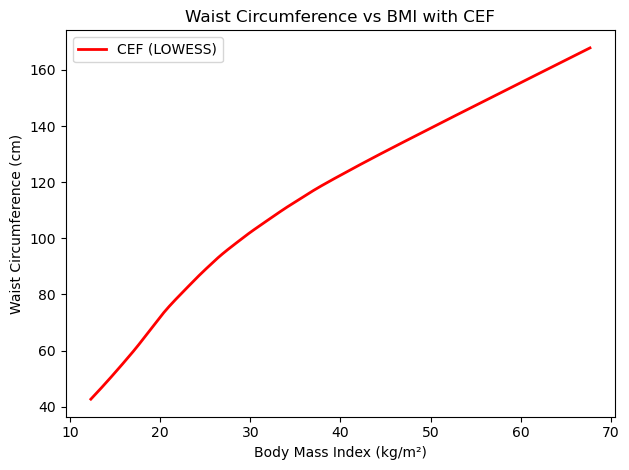

In [115]:
lowess_fit = lowess(subset[y_var], subset[x_var], frac=0.3)
plt.plot(lowess_fit[:,0], lowess_fit[:,1], color="red", linewidth=2, label="CEF (LOWESS)")

plt.title("Waist Circumference vs BMI with CEF")
plt.xlabel("Body Mass Index (kg/m²)")
plt.ylabel("Waist Circumference (cm)")
plt.legend()
plt.tight_layout()
plt.show()

The relationship between Body Mass Index (BMI) and waist circumference is unlikely to be purely causal in the sense of BMI directly causing changes in waist size. Instead, both are measures of body composition that reflect underlying factors such as diet, exercise, genetics, and lifestyle. For example, two individuals with the same BMI could have different waist circumferences depending on how their body stores fat. Additionally, unobserved variables like muscle mass, metabolic health, or hormonal factors could influence both BMI and waist size simultaneously. These confounders present clear threats to causal identification because the observed correlation might reflect these shared underlying influences rather than a direct causal effect.

That said, even without establishing a strict causal pathway, the relationship remains useful for prediction. Since BMI and waist circumference are strongly correlated, a model using BMI as an input can provide reasonably accurate estimates of waist circumference in a population. The key is that prediction does not require ruling out confounders—it only requires a stable statistical association. As long as we are not attempting to manipulate BMI in order to achieve a specific waist size outcome, but rather using BMI as an observed predictor, the model remains valid and practical for forecasting or risk assessment purposes.